In [1]:
import ee
import geemap
import pandas as pd
from matplotlib import pyplot


#ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()


#--------------------------Middle Branch Lake-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Middle Branch Lake'))
#-------------------------------------------------------------------------------------------------------

#-------------------------Indian Lake-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Indian Lake')).filter(ee.Filter.eq('COUNTY','20'))
#----------------------------------------------------------------------------------------------------------

#--------------------------Squaw Lake-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Squaw Lake'))
#-------------------------------------------------------------------------------------------------------

#--------------------------Limekiln Lake-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Limekiln Lake'))
#-------------------------------------------------------------------------------------------------------

#--------------------------Jockeybush Lake-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Jockeybush Lake'))
#-------------------------------------------------------------------------------------------------------

#--------------------------South Lake-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'South Lake'))
#-------------------------------------------------------------------------------------------------------


#-------------------------Willys Lake-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Willys Lake'))
#------------------------------------------------------------------------------------------------



#-------------------------Middle Settlement Lake-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Middle Settlement Lake'))
#----------------------------------------------------------------------------------------------------------



#----------------------------Carry Pond-----------------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Carry Pond'))
#-------------------------------------------------------------------------------------------------------


#----------------------------G Lake-----------------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'G Lake'))
#-------------------------------------------------------------------------------------------------------


#---------------------------BIG MOOSE LAKE------------------------------------------------------------
lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
    .filter(ee.Filter.eq('GNIS_Name', 'Big Moose Lake'))
#-----------------------------------------------------------------------------------------------------


#---------------------------Avalanche Lake------------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Avalanche Lake'))
#-------------------------------------------------------------------------------------------------------


#--------------------------Cascade Lake Lake-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Cascade Lake'))
#-------------------------------------------------------------------------------------------------------


#--------------------------Sagamore Lake-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Sagamore Lake'))
#-------------------------------------------------------------------------------------------------------


#--------------------------Moss Lake-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Moss Lake'))
#-------------------------------------------------------------------------------------------------------


#-------------------------Raquette Lake Reservoir-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Raquette Lake Reservoir'))
#------------------------------------------------------------------------------------------------


#-------------------------Middle Branch Lake-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Middle Branch Lake'))
#----------------------------------------------------------------------------------------------------------



Map.addLayer(lake)
Map.centerObject(lake, 16)
Map






Map(center=[43.83093869244275, -74.84826397158908], controls=(WidgetControl(options=['position', 'transparent_…

In [2]:
LC5_BANDS = ['SR_B1',   'SR_B2',    'SR_B3',  'SR_B4',  'SR_B5',    'SR_B7',    'ST_B6','QA_PIXEL']; #Llandsat 5
LC8_BANDS = ['SR_B2','SR_B3','SR_B4',  'SR_B5','SR_B6','SR_B7','ST_B10','QA_PIXEL']; #Landsat 8
STD_NAMES = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'temp','QA'];

def cdom(img):
    cdo = img.expression("(20.3 - 10. * (b2 / b3) - 2.4 * (b3 / b4))", {
        'b1' : img.select('blue'),
        'b2' : img.select('green'),
        'b3' : img.select('red'),
        'b4' : img.select('nir')
    }).rename("CO")
    
    bad2 = cdo.where((cdo.gte(0)),1).rename("bad2");
    co= cdo.multiply(bad2).rename("CO");
    mask = co.neq(0);

    return img.addBands([co]).clip(lake).updateMask(mask)

def maskL457sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    qa = image.select('QA_PIXEL')
    cloud = qa.bitwiseAnd(1 << 5).Or(qa.bitwiseAnd(1 << 7)).Or(qa.bitwiseAnd(1 << 3))
    masked = image.updateMask(cloud.Not())
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(-124.15)
    return image.addBands(opticalBands, None, True).addBands(thermalBand, None, True).updateMask(masked).updateMask(qaMask).updateMask(saturationMask)


l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
   .filter(ee.Filter.calendarRange(9, 10, 'month')) \
   .filterBounds(lake) \
   .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
   .map(maskL457sr)\
   .select(LC5_BANDS, STD_NAMES)\
   .map(cdom)\
   
def maskL8sr(image):
    
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)

    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(-124.15)

    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
        .addBands(thermalBands, None, True) \
        .updateMask(qaMask) \
        .updateMask(saturationMask)

l8 =ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(9, 10, 'month')) \
    .filterBounds(lake) \
    .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
    .map(maskL8sr) \
    .select(LC8_BANDS, STD_NAMES)\
    .map(cdom) \




#merge landsat 5 and landsat 8
lall = ee.ImageCollection(l5.merge(l8));



In [6]:
def reflectance(img):
    reflectance_values = img.reduceRegion(reducer=ee.Reducer.median(), geometry=lake, scale=30).select(STD_NAMES)
    return img.set('date', img.date().format()).set('reflectance',reflectance_values)

map_reflectance = lall.map(reflectance)
list_relfectance = map_reflectance.reduceColumns(ee.Reducer.toList(2), ['date','reflectance']).values().get(0)

df_reflectance = pd.DataFrame(list_relfectance.getInfo(), columns=['date','reflectance'])
pd.set_option('display.max_rows', None)
df_reflectance['date'] = pd.to_datetime(df_reflectance['date'])
df_reflectance['date'] = df_reflectance['date'].dt.date
df_reflectance['reflectance'] = df_reflectance['reflectance'].apply(lambda x: {k: v for k, v in x.items() if v is not None})
df_reflectance



,date,reflectance
0,1984-09-21,"{'QA': 5440, 'blue': 0.023265662953995146, 'gr..."
1,1984-10-07,"{'QA': 5440, 'blue': 0.02454440470255899, 'gre..."
2,1985-10-26,"{'QA': 5440, 'blue': 0.018173371010638293, 'gr..."
3,1987-10-16,"{'QA': 5440, 'blue': 0.027876456760466708, 'gr..."
4,1988-09-16,"{'QA': 5440, 'blue': 0.016909089063939956, 'gr..."
5,1989-09-03,"{'QA': 5440, 'blue': 0.015753625285062706, 'gr..."
6,1989-10-05,"{'QA': 5440, 'blue': 0.021116071226814796, 'gr..."
7,1991-09-09,{}
8,1993-10-16,"{'QA': 5440, 'blue': 0.039891416071739495, 'gr..."
9,1994-10-03,"{'QA': 5440, 'blue': 0.02710753491399716, 'gre..."


In [7]:
import pandas as pd

# Create empty lists to store the data
data = []

# Extract the bands, reflectance values, and dates where available
for index, row in df_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    if reflectance:
        for band in STD_NAMES:
            value = reflectance.get(band)
            data.append({'Band': band, 'Reflectance': value, 'Date': date})

# Create a dataframe from the data
df_data = pd.DataFrame(data)

# Display the dataframe
print(df_data)



      Band   Reflectance        Date
0     blue      0.023266  1984-09-21
1    green      0.028908  1984-09-21
2      red      0.023215  1984-09-21
3      nir      0.072887  1984-09-21
4    swir1      0.032433  1984-09-21
5    swir2      0.015687  1984-09-21
6     temp     13.987153  1984-09-21
7       QA   5440.000000  1984-09-21
8     blue      0.024544  1984-10-07
9    green      0.030376  1984-10-07
10     red      0.024086  1984-10-07
11     nir      0.061906  1984-10-07
12   swir1      0.033002  1984-10-07
13   swir2      0.017706  1984-10-07
14    temp     11.110494  1984-10-07
15      QA   5440.000000  1984-10-07
16    blue      0.018173  1985-10-26
17   green      0.027149  1985-10-26
18     red      0.023797  1985-10-26
19     nir      0.073564  1985-10-26
20   swir1      0.051075  1985-10-26
21   swir2      0.026743  1985-10-26
22    temp      9.889173  1985-10-26
23      QA   5440.000000  1985-10-26
24    blue      0.027876  1987-10-16
25   green      0.031399  1987-10-16
2

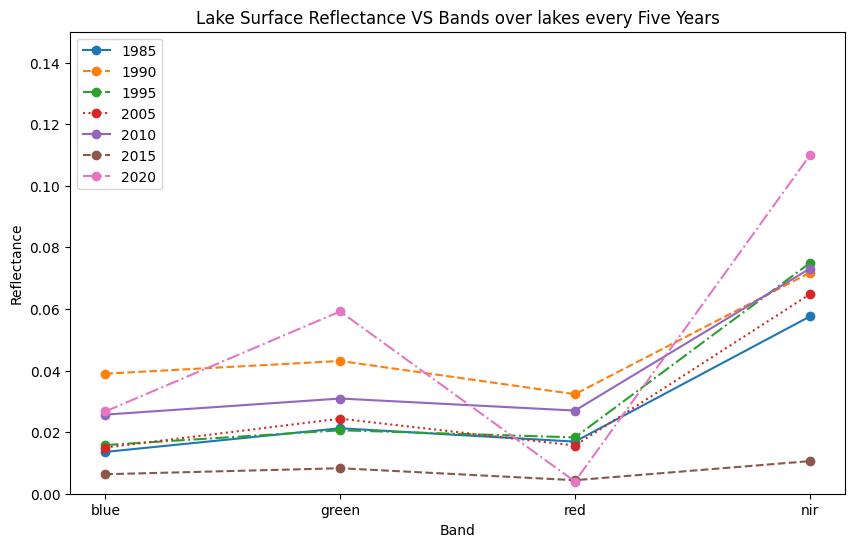

In [9]:
import matplotlib.pyplot as plt
import numpy as np

data_by_year = {}

for index, row in df_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']

    def myRange(start, end, step):
        i = start
        while i < end:
            yield i
            i += step
        yield end

    for i in myRange(1985, 2023, 5):
        #print(i)

        if (i == date.year) and date.month == 9:
            year = date.year

            if year not in data_by_year:
                data_by_year[year] = {'band': [], 'reflectance': []}

            if reflectance:
                for band in STD_NAMES:
                    value = reflectance.get(band)
                    data_by_year[year]['band'].append(band)
                    data_by_year[year]['reflectance'].append(value)

# Calculate average reflectance values for each year
averaged_data_by_year = {}
for year, data in data_by_year.items():
    red_index = data['band'].index('red')
    green_index = data['band'].index('green')
    nir_index = data['band'].index('nir')


    averaged_data_by_year[year] = {
        'band': ['blue', 'green', 'red', 'nir'],
        'reflectance': [
            data['reflectance'][data['band'].index('blue')],
            data['reflectance'][data['band'].index('green')],
            data['reflectance'][red_index],
            data['reflectance'][nir_index]
        ]
    }

# Sort the averaged_data_by_year dictionary based on the keys (years) in ascending order
sorted_data_by_year = dict(sorted(averaged_data_by_year.items()))

plt.figure(figsize=(10, 6))

line_styles = ['-', '--', '-.', ':']  # List of line styles
num_styles = len(line_styles)
style_index = 0

for year, data in sorted_data_by_year.items():
    line_style = line_styles[style_index % num_styles]  # Cycle through line styles
    plt.plot(data['band'], data['reflectance'], linestyle=line_style, marker='o', label=year)
    style_index += 1

    # Get the name of the lake
plt.xlabel('Band')
plt.ylabel('Reflectance')
plt.ylim(0, 0.15)
plt.title('Lake Surface Reflectance VS Bands over lakes every Five Years')
plt.legend()
plt.show()
